In [134]:
import keras
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from matplotlib.dates import YearLocator, DateFormatter, MonthLocator
from keras.api.layers import LSTM, Dense, Dropout, Input
from keras.api.models import Sequential, load_model
from keras.api.callbacks import ModelCheckpoint
from keras.api.metrics import R2Score, MeanAbsoluteError, MeanAbsolutePercentageError
from sklearn.preprocessing import MinMaxScaler, StandardScaler

### <b> ĐỌC DỮ LIỆU </b>

In [90]:
df = pd.read_csv("du_lieu_FPT4.csv")
df

,Ngày,Giá mở,Giá cao nhất,Giá thấp nhất,Giá đóng,Giá điều chỉnh,Giá trị thay đổi,% thay đổi,Tổng KL GD,Tổng GT GD
0,01/11/2024,135.0,135.0,133.6,134.6,--,-1.3,-0.96,"2,667,500",358.25
1,31/10/2024,135.9,136.0,135.3,135.9,--,0.0,0.00,"1,241,700",168.45
2,30/10/2024,135.4,135.9,135.2,135.9,--,0.5,0.37,"1,709,800",231.78
3,29/10/2024,135.4,135.5,134.8,135.4,--,0.5,0.37,"2,459,200",332.04
4,28/10/2024,134.1,135.0,133.6,134.9,--,0.9,0.67,"1,506,000",202.64
...,...,...,...,...,...,...,...,...,...,...
2696,08/01/2014,47.4,48.0,47.4,47.8,6.55,0.3,0.63,"129,600",6.19
2697,07/01/2014,48.0,48.0,47.5,47.5,6.51,-0.5,-1.04,"290,990",13.91
2698,06/01/2014,47.3,48.0,47.0,48.0,6.57,0.7,1.48,"301,670",14.29
2699,03/01/2014,47.3,47.4,47.0,47.3,6.48,-0.1,-0.21,"165,110",7.8


### <b> MÔ TẢ DỮ LIỆU </b>

In [91]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2701 entries, 0 to 2700
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Ngày              2701 non-null   object 
 1   Giá mở            2701 non-null   float64
 2   Giá cao nhất      2701 non-null   float64
 3   Giá thấp nhất     2701 non-null   float64
 4   Giá đóng          2701 non-null   float64
 5   Giá điều chỉnh    2701 non-null   object 
 6   Giá trị thay đổi  2701 non-null   float64
 7   % thay đổi        2701 non-null   float64
 8   Tổng KL GD        2701 non-null   object 
 9   Tổng GT GD        2701 non-null   object 
dtypes: float64(6), object(4)
memory usage: 211.1+ KB


In [92]:
df.shape

(2701, 10)

In [93]:
df.describe()

,Giá mở,Giá cao nhất,Giá thấp nhất,Giá đóng,Giá trị thay đổi,% thay đổi
count,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000,2701.000000
mean,65.393280,66.108423,64.743854,65.414235,0.071114,0.108638
std,24.810934,25.114200,24.525931,24.841101,1.190148,1.649832
min,38.800000,39.650000,38.500000,38.800000,-10.800000,-11.030000
25%,46.900000,47.300000,46.550000,46.900000,-0.400000,-0.700000
50%,53.000000,53.700000,52.400000,53.000000,0.000000,0.000000
75%,83.200000,84.000000,82.600000,83.100000,0.500000,0.880000
max,144.300000,146.500000,143.100000,146.500000,7.800000,7.000000


### <b> TIỀN XỬ LÝ DỮ LIỆU </b>

In [94]:
df["Ngày"] = pd.to_datetime(df["Ngày"], format="%d/%m/%Y")

In [95]:
df = df.sort_values(by="Ngày", ascending=False)
df

,Ngày,Giá mở,Giá cao nhất,Giá thấp nhất,Giá đóng,Giá điều chỉnh,Giá trị thay đổi,% thay đổi,Tổng KL GD,Tổng GT GD
0,2024-11-01,135.0,135.0,133.6,134.6,--,-1.3,-0.96,"2,667,500",358.25
1,2024-10-31,135.9,136.0,135.3,135.9,--,0.0,0.00,"1,241,700",168.45
2,2024-10-30,135.4,135.9,135.2,135.9,--,0.5,0.37,"1,709,800",231.78
3,2024-10-29,135.4,135.5,134.8,135.4,--,0.5,0.37,"2,459,200",332.04
4,2024-10-28,134.1,135.0,133.6,134.9,--,0.9,0.67,"1,506,000",202.64
...,...,...,...,...,...,...,...,...,...,...
2696,2014-01-08,47.4,48.0,47.4,47.8,6.55,0.3,0.63,"129,600",6.19
2697,2014-01-07,48.0,48.0,47.5,47.5,6.51,-0.5,-1.04,"290,990",13.91
2698,2014-01-06,47.3,48.0,47.0,48.0,6.57,0.7,1.48,"301,670",14.29
2699,2014-01-03,47.3,47.4,47.0,47.3,6.48,-0.1,-0.21,"165,110",7.8


In [96]:
df['Giá mở'] = df['Giá mở'].astype(float)
df['Giá đóng'] = df['Giá đóng'].astype(float)
df['Giá cao nhất'] = df['Giá cao nhất'].astype(float)
df['Giá thấp nhất'] = df['Giá thấp nhất'].astype(float)
df['Tổng KL GD'] = df['Tổng KL GD'].replace({',': ''}, regex=True).astype(float)
df['Tổng GT GD'] = df['Tổng GT GD'].replace({',': ''}, regex=True).astype(float)

df = df.sort_values(by="Ngày", ascending=False)
df

,Ngày,Giá mở,Giá cao nhất,Giá thấp nhất,Giá đóng,Giá điều chỉnh,Giá trị thay đổi,% thay đổi,Tổng KL GD,Tổng GT GD
0,2024-11-01,135.0,135.0,133.6,134.6,--,-1.3,-0.96,2667500.0,358.25
1,2024-10-31,135.9,136.0,135.3,135.9,--,0.0,0.00,1241700.0,168.45
2,2024-10-30,135.4,135.9,135.2,135.9,--,0.5,0.37,1709800.0,231.78
3,2024-10-29,135.4,135.5,134.8,135.4,--,0.5,0.37,2459200.0,332.04
4,2024-10-28,134.1,135.0,133.6,134.9,--,0.9,0.67,1506000.0,202.64
...,...,...,...,...,...,...,...,...,...,...
2696,2014-01-08,47.4,48.0,47.4,47.8,6.55,0.3,0.63,129600.0,6.19
2697,2014-01-07,48.0,48.0,47.5,47.5,6.51,-0.5,-1.04,290990.0,13.91
2698,2014-01-06,47.3,48.0,47.0,48.0,6.57,0.7,1.48,301670.0,14.29
2699,2014-01-03,47.3,47.4,47.0,47.3,6.48,-0.1,-0.21,165110.0,7.80


In [97]:
df["Giá điều chỉnh"] = df["Giá điều chỉnh"].replace("--", 0).astype(float)
df

,Ngày,Giá mở,Giá cao nhất,Giá thấp nhất,Giá đóng,Giá điều chỉnh,Giá trị thay đổi,% thay đổi,Tổng KL GD,Tổng GT GD
0,2024-11-01,135.0,135.0,133.6,134.6,0.00,-1.3,-0.96,2667500.0,358.25
1,2024-10-31,135.9,136.0,135.3,135.9,0.00,0.0,0.00,1241700.0,168.45
2,2024-10-30,135.4,135.9,135.2,135.9,0.00,0.5,0.37,1709800.0,231.78
3,2024-10-29,135.4,135.5,134.8,135.4,0.00,0.5,0.37,2459200.0,332.04
4,2024-10-28,134.1,135.0,133.6,134.9,0.00,0.9,0.67,1506000.0,202.64
...,...,...,...,...,...,...,...,...,...,...
2696,2014-01-08,47.4,48.0,47.4,47.8,6.55,0.3,0.63,129600.0,6.19
2697,2014-01-07,48.0,48.0,47.5,47.5,6.51,-0.5,-1.04,290990.0,13.91
2698,2014-01-06,47.3,48.0,47.0,48.0,6.57,0.7,1.48,301670.0,14.29
2699,2014-01-03,47.3,47.4,47.0,47.3,6.48,-0.1,-0.21,165110.0,7.80


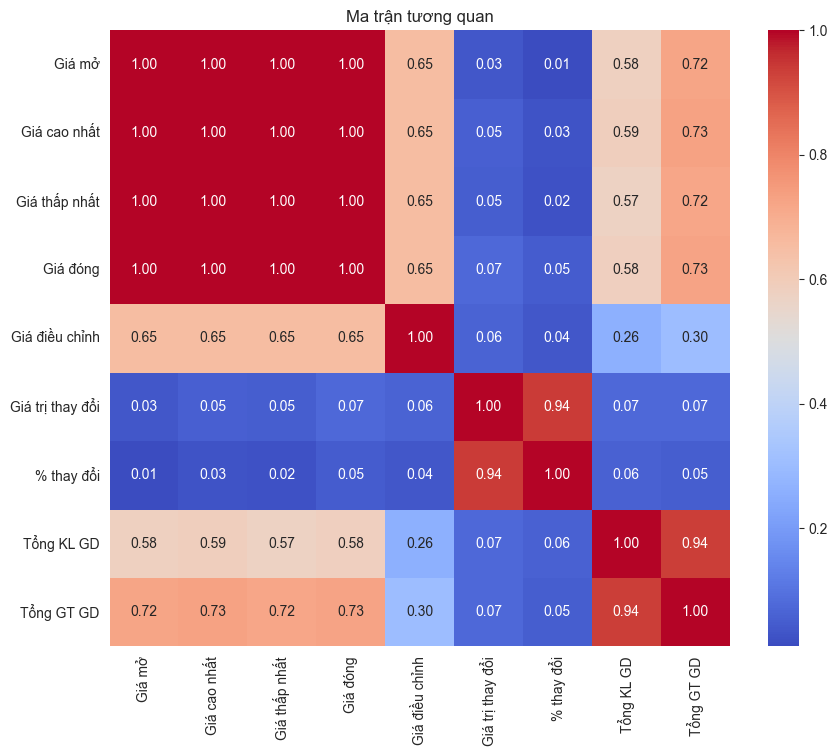

In [98]:
df_numeric = df.drop(columns=['Ngày'])
plt.figure(figsize=(10, 8))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Ma trận tương quan")
plt.show()

In [101]:
df["Năm"] = df["Ngày"].dt.year
df

,Ngày,Giá mở,Giá cao nhất,Giá thấp nhất,Giá đóng,Giá điều chỉnh,Giá trị thay đổi,% thay đổi,Tổng KL GD,Tổng GT GD,Năm
0,2024-11-01,135.0,135.0,133.6,134.6,0.00,-1.3,-0.96,2667500.0,358.25,2024
1,2024-10-31,135.9,136.0,135.3,135.9,0.00,0.0,0.00,1241700.0,168.45,2024
2,2024-10-30,135.4,135.9,135.2,135.9,0.00,0.5,0.37,1709800.0,231.78,2024
3,2024-10-29,135.4,135.5,134.8,135.4,0.00,0.5,0.37,2459200.0,332.04,2024
4,2024-10-28,134.1,135.0,133.6,134.9,0.00,0.9,0.67,1506000.0,202.64,2024
...,...,...,...,...,...,...,...,...,...,...,...
2696,2014-01-08,47.4,48.0,47.4,47.8,6.55,0.3,0.63,129600.0,6.19,2014
2697,2014-01-07,48.0,48.0,47.5,47.5,6.51,-0.5,-1.04,290990.0,13.91,2014
2698,2014-01-06,47.3,48.0,47.0,48.0,6.57,0.7,1.48,301670.0,14.29,2014
2699,2014-01-03,47.3,47.4,47.0,47.3,6.48,-0.1,-0.21,165110.0,7.80,2014


In [102]:
df["Năm"].value_counts()

Năm
2020    251
2016    251
2021    250
2019    250
2017    250
2023    249
2022    249
2018    248
2015    248
2014    247
2024    208
Name: count, dtype: int64

In [103]:
df.columns

Index(['Ngày', 'Giá mở', 'Giá cao nhất', 'Giá thấp nhất', 'Giá đóng',
       'Giá điều chỉnh', 'Giá trị thay đổi', '% thay đổi', 'Tổng KL GD',
       'Tổng GT GD', 'Năm'],
      dtype='object')

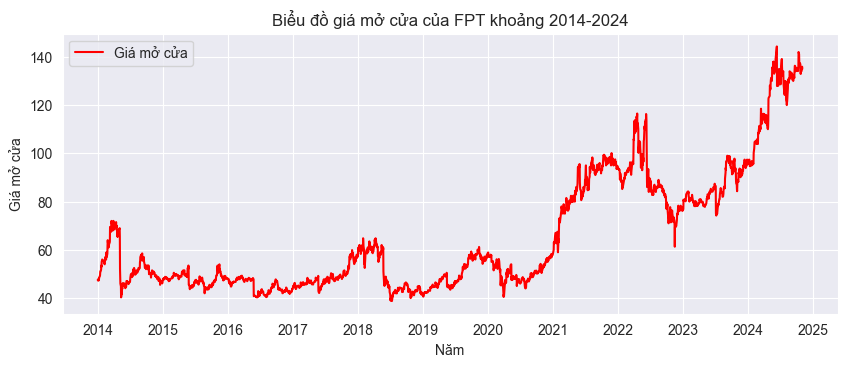

In [106]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(df['Ngày'], df['Giá mở'], label='Giá mở cửa', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá mở cửa')
plt.title('Biểu đồ giá mở cửa của FPT khoảng 2014-2024')
plt.legend(loc='best')
plt.grid(True)

years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

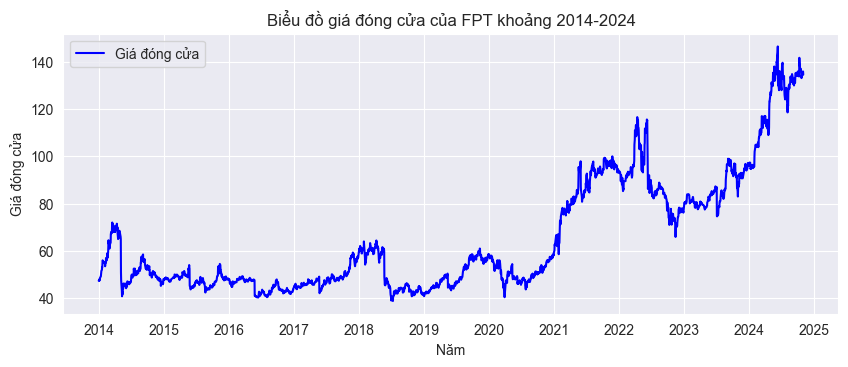

In [107]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(df['Ngày'], df['Giá đóng'], label='Giá đóng cửa', color='blue')
plt.xlabel('Năm')
plt.ylabel('Giá đóng cửa')
plt.title('Biểu đồ giá đóng cửa của FPT khoảng 2014-2024')
plt.legend(loc='best')
plt.grid(True)

years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

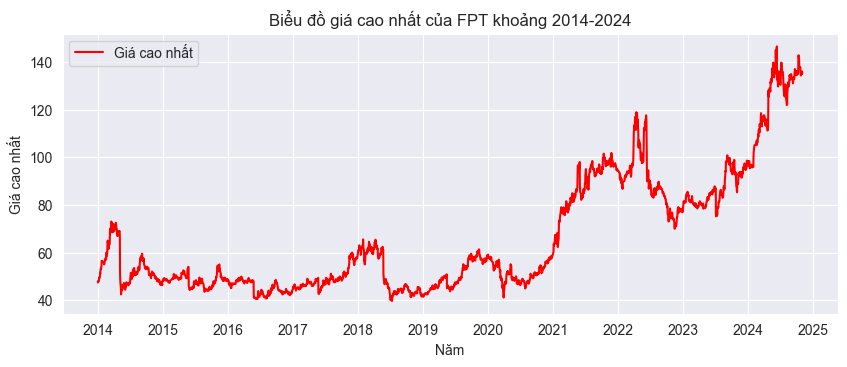

In [108]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(df['Ngày'], df['Giá cao nhất'], label='Giá cao nhất', color='red')
plt.xlabel('Năm')
plt.ylabel('Giá cao nhất')
plt.title('Biểu đồ giá cao nhất của FPT khoảng 2014-2024')
plt.legend(loc='best')
plt.grid(True)

years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

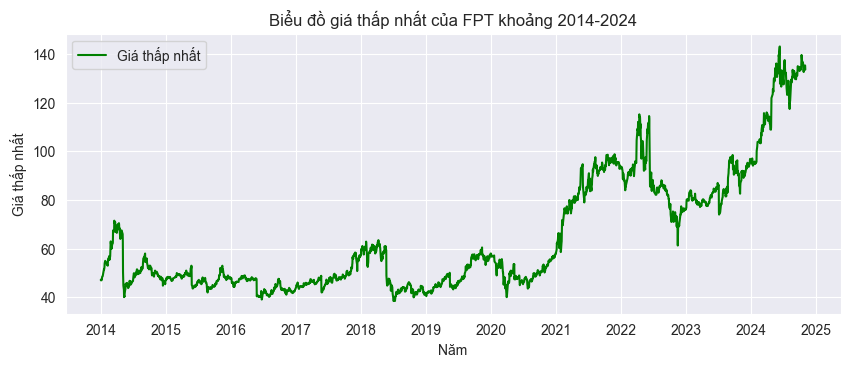

In [109]:
plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(df['Ngày'], df['Giá thấp nhất'], label='Giá thấp nhất', color='green')
plt.xlabel('Năm')
plt.ylabel('Giá thấp nhất')
plt.title('Biểu đồ giá thấp nhất của FPT khoảng 2014-2024')
plt.legend(loc='best')
plt.grid(True)

years = YearLocator()
yearsFmt = DateFormatter('%Y')
months = MonthLocator()
plt.gca().xaxis.set_major_locator(years)
plt.gca().xaxis.set_major_formatter(yearsFmt)
plt.gca().xaxis.set_minor_locator(months)

In [160]:
def normalize(data, train_split):
    scaler = MinMaxScaler()
    scaler.fit(data[:train_split])
    
    scale_data = scaler.transform(data)
    
    return scale_data, scaler

In [112]:
def inverse_normalize(scale_data, scaler):
    return scaler.inverse_transform(scale_data)

In [117]:
train_split = int(0.7 * df.shape[0])
val_split = int(0.15 * df.shape[0])
test_split = int(0.15 * df.shape[0])

train_split, val_split, test_split

(1890, 405, 405)

In [120]:
df.set_index("Ngày", inplace=True)
df

,Giá mở,Giá cao nhất,Giá thấp nhất,Giá đóng,Giá điều chỉnh,Giá trị thay đổi,% thay đổi,Tổng KL GD,Tổng GT GD,Năm
Ngày,,,,,,,,,,
2024-11-01,135.0,135.0,133.6,134.6,0.00,-1.3,-0.96,2667500.0,358.25,2024
2024-10-31,135.9,136.0,135.3,135.9,0.00,0.0,0.00,1241700.0,168.45,2024
2024-10-30,135.4,135.9,135.2,135.9,0.00,0.5,0.37,1709800.0,231.78,2024
2024-10-29,135.4,135.5,134.8,135.4,0.00,0.5,0.37,2459200.0,332.04,2024
2024-10-28,134.1,135.0,133.6,134.9,0.00,0.9,0.67,1506000.0,202.64,2024
...,...,...,...,...,...,...,...,...,...,...
2014-01-08,47.4,48.0,47.4,47.8,6.55,0.3,0.63,129600.0,6.19,2014
2014-01-07,48.0,48.0,47.5,47.5,6.51,-0.5,-1.04,290990.0,13.91,2014
2014-01-06,47.3,48.0,47.0,48.0,6.57,0.7,1.48,301670.0,14.29,2014


In [161]:
df_normalize, scaler = normalize(df, train_split + val_split)

In [162]:
train_data = df_normalize[:train_split]
val_data = df_normalize[train_split:train_split + val_split]
test_data = df_normalize[train_split + val_split:]

In [123]:
past = 15
future = 1
step = 1
batch_size = 256

In [163]:
start_train = past + future - 1
end_train = start_train + train_split

X_train = train_data
y_train = df_normalize[start_train:end_train, :]
sequence_length = int(past / step)
dataset_train = keras.api.preprocessing.timeseries_dataset_from_array(
    X_train,
    y_train,
    sequence_length=sequence_length,
    batch_size=batch_size,
)

In [164]:
start_val = end_train
end_val = start_val + val_split

X_val = val_data
y_val = df_normalize[start_val:end_val, :]

dataset_val = keras.api.preprocessing.timeseries_dataset_from_array(
    X_val,
    y_val,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [165]:
start_test = end_val
end_test = len(df_normalize) - past

X_test = test_data[:end_test - start_test]
y_test = df_normalize[start_test:, :]

dataset_test = keras.api.preprocessing.timeseries_dataset_from_array(
    X_test,
    y_test,
    sequence_length=sequence_length,
    sampling_rate=step,
    batch_size=batch_size,
)

In [166]:
X_train.shape, y_train.shape

((1890, 10), (1890, 10))

### <b> XÂY DỰNG VÀ HUẤN LUYỆN MÔ HÌNH </b>

In [171]:
model = Sequential([
    Input(shape=(sequence_length, X_train.shape[1])),
    LSTM(128, return_sequences=True),
    LSTM(64),
    Dense(128),
    Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_absolute_error'])

model.summary()

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_21 (LSTM)                  │ (None, 15, 128)        │        71,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_22 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 129,025 (504.00 KB)

 Trainable params: 129,025 (504.00 KB)

 Non-trainable params: 0 (0.00 B)

In [172]:
save_model = "my_model.keras"
best_model = ModelCheckpoint(save_model,monitor='loss',verbose=2,save_best_only=True,mode='auto')
history = model.fit(dataset_train,
                    epochs=100,
                    batch_size=32,
                    verbose=2,
                    callbacks=[best_model],
                    validation_data=dataset_val)

Epoch 1/100

Epoch 1: loss improved from inf to 0.12145, saving model to my_model.keras
8/8 - 3s - 359ms/step - loss: 0.1214 - mean_absolute_error: 0.2811 - val_loss: 0.0511 - val_mean_absolute_error: 0.1413
Epoch 2/100

Epoch 2: loss improved from 0.12145 to 0.06326, saving model to my_model.keras
8/8 - 0s - 43ms/step - loss: 0.0633 - mean_absolute_error: 0.1771 - val_loss: 0.0531 - val_mean_absolute_error: 0.1347
Epoch 3/100

Epoch 3: loss improved from 0.06326 to 0.05124, saving model to my_model.keras
8/8 - 0s - 41ms/step - loss: 0.0512 - mean_absolute_error: 0.1888 - val_loss: 0.0493 - val_mean_absolute_error: 0.1953
Epoch 4/100

Epoch 4: loss improved from 0.05124 to 0.04908, saving model to my_model.keras
8/8 - 0s - 43ms/step - loss: 0.0491 - mean_absolute_error: 0.1810 - val_loss: 0.0478 - val_mean_absolute_error: 0.1775
Epoch 5/100

Epoch 5: loss did not improve from 0.04908
8/8 - 0s - 40ms/step - loss: 0.0511 - mean_absolute_error: 0.1887 - val_loss: 0.0479 - val_mean_absolut

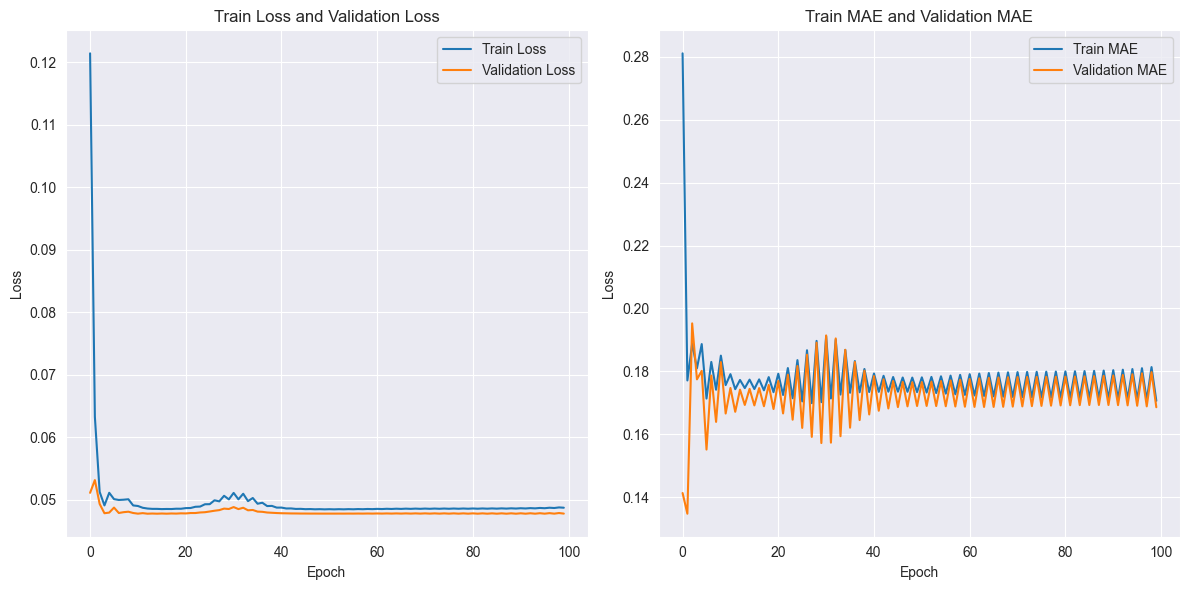

In [173]:
plt.figure(figsize=(12, 6))
# Vẽ biểu đồ hàm loss
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train Loss and Validation Loss')
plt.grid(True)

# Vẽ biểu đồ hàm MAE
plt.subplot(1,2,2)
plt.plot(history.history['mean_absolute_error'], label='Train MAE')
plt.plot(history.history['val_mean_absolute_error'], label='Validation MAE')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Train MAE and Validation MAE')

plt.grid(True)
plt.tight_layout()
plt.show()

In [175]:
pd.DataFrame(df_normalize)

,0,1,2,3,4,5,6,7,8,9
0,0.911848,0.892372,0.909178,0.889508,0.000000,0.510753,0.558514,0.189220,0.199174,1.000000
1,0.920379,0.901731,0.925430,0.901578,0.000000,0.580645,0.611758,0.084503,0.092466,1.000000
2,0.915640,0.900796,0.924474,0.901578,0.000000,0.607527,0.632280,0.118882,0.128071,1.000000
3,0.915640,0.897052,0.920650,0.896936,0.000000,0.607527,0.632280,0.173922,0.184438,1.000000
4,0.903318,0.892372,0.909178,0.892293,0.000000,0.629032,0.648918,0.103914,0.111688,1.000000
...,...,...,...,...,...,...,...,...,...,...
2696,0.081517,0.078147,0.085086,0.083565,0.051770,0.596774,0.646700,0.002825,0.001242,-0.111111
2697,0.087204,0.078147,0.086042,0.080780,0.051454,0.553763,0.554077,0.014678,0.005583,-0.111111
2698,0.080569,0.078147,0.081262,0.085422,0.051929,0.618280,0.693844,0.015462,0.005796,-0.111111
2699,0.080569,0.072532,0.081262,0.078923,0.051217,0.575269,0.600111,0.005433,0.002148,-0.111111
